In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras 
import os 

In [ ]:
[m for m in dir(keras.applications) if not m.startswith('_')]

In [22]:
(x_train, y_train), (x_test_full, y_test_full) = keras.datasets.cifar100.load_data()


In [23]:
x_train = x_train / 255.
x_valid, y_valid = x_test_full[:5000] / 255., y_test_full[:5000]
x_test, y_test = x_test_full[5000:] / 255., y_test_full[5000:]

In [26]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_valid = y_valid.reshape(-1)



In [34]:
classes = [
    "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn mower", "leopard", "lion", "lizard", "lobster", "man", "maple tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak tree", "orange", "orchid", "otter", "palm tree", "pear", "pickup truck", "pine tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"
]


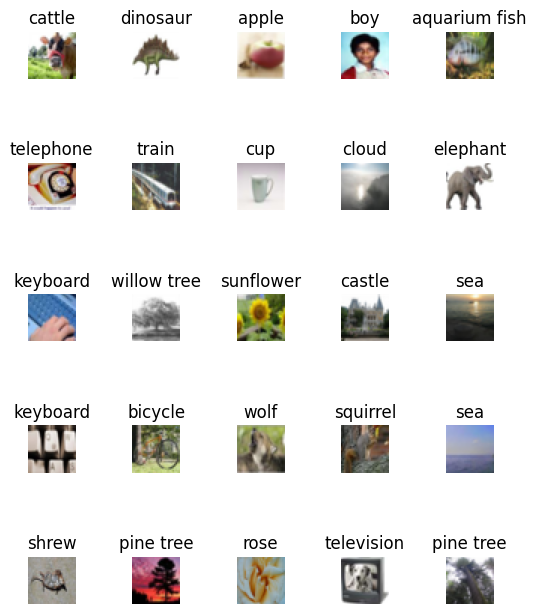

In [35]:
import matplotlib.pyplot as plt 
rows = 5
columns = 5 
plt.figure(figsize=(rows*1.2, columns*1.5))
for r in range(rows):
    for c in range(columns):
        index = columns * r + c
        plt.subplot(rows, columns, index+1)
        plt.axis('off')
        plt.imshow(x_train[index])
        plt.title(classes[y_train[index]])
plt.subplots_adjust(wspace=1.2, hspace=1.5)


In [42]:
conv = keras.layers.Conv2D(filters=3, padding='same', strides=1, kernel_size=3, activation='elu')
output = conv(x_train[0:2])


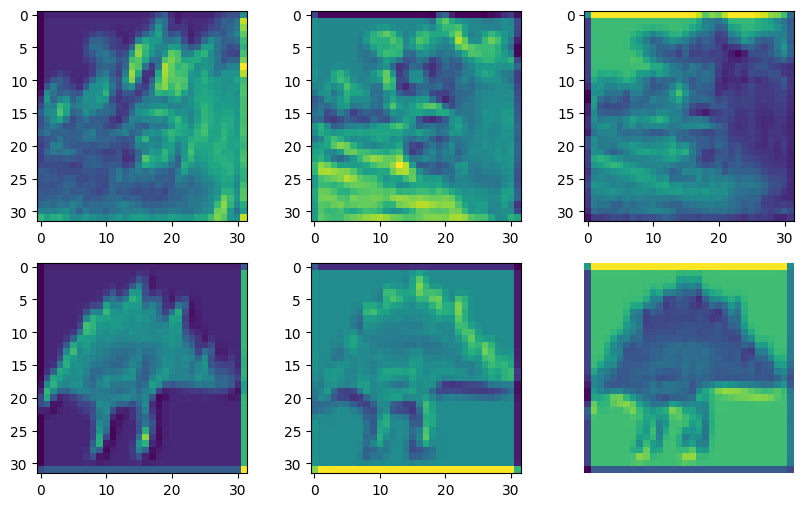

In [48]:
num_images = 2
num_filters = 3

plt.figure(figsize=(10, 6))
for image_index in range(num_images):
    for filter_index in range(num_filters):
        plt.subplot(num_images, num_filters, image_index * num_filters + filter_index + 1)
        plt.imshow(output[image_index, :, :, filter_index], cmap="viridis")
plt.axis("off")  # Hide axes for better visualization
plt.show()


In [54]:
from functools import partial 
default_layer = partial(keras.layers.Conv2D, kernel_size=3, padding='SAME', strides=1, use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers= [
            default_layer(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            default_layer(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                default_layer(filters, strides=strides),
                keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        skip_z = inputs
        for skip_layer in self.skip_layers:
            skip_z = skip_layer(skip_z)
        return self.activation(z + skip_z)

In [66]:
model = keras.models.Sequential()
model.add(default_layer(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="softmax"))

c:\Users\ibrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
def exponential_decay(lr=0.1, s=20):
    def func(epoch):
        return lr * (0.1**(epoch/s))
    return func

learning_rate_exponential = exponential_decay()

optimizer = keras.optimizers.Nadam(learning_rate= 0.1, beta_1=0.9, beta_2=0.999, decay=1e-4)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_exponential)



c:\Users\ibrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), callbacks=[lr_scheduler])
score = model.evaluate(x_test, y_test)
